# Analyzing the S&P Data

## Narrowing down to 1994 - 1996 Date Range



In [1]:
# Import libraries
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()  # seaborn defaults

In [2]:
# import the data
df = pd.read_csv('data/quarterly-sp-500-index-19001996.csv', header=0)

### I. Inspecting the data

In [3]:
df.head()

,Quarter,"Quarterly S&P 500 index, 1900-1996"
0,1900Q1,1.199
1,1900Q2,1.300
2,1900Q3,1.348
3,1900Q4,1.455
4,1901Q1,1.552


In [4]:
df.tail()

,Quarter,"Quarterly S&P 500 index, 1900-1996"
384,1996Q1,1.559
385,1996Q2,1.585
386,1996Q3,1.788
387,1996Q4,1.817
388,Quarterly S&P 500 index,1900-1996


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 2 columns):
Quarter                               389 non-null object
Quarterly S&P 500 index, 1900-1996    389 non-null object
dtypes: object(2)
memory usage: 6.2+ KB


In [6]:
df.shape

(389, 2)

### II. Wrangling the data

In [7]:
# drop the last row (no data)
df = df.drop(388)

In [8]:
df.shape

(388, 2)

In [9]:
# New column names
names = ['date', 'sp_index']
df.columns = names

In [10]:
df.head()

,date,sp_index
0,1900Q1,1.199
1,1900Q2,1.300
2,1900Q3,1.348
3,1900Q4,1.455
4,1901Q1,1.552


In [11]:
# What is the sp_index data type
type(df.sp_index.iloc[0])

str

In [12]:
# Change the data type to numeric
df.sp_index = df.sp_index.astype('float')

In [13]:
# desriptive stats
df.describe()

,sp_index
count,388.000000
mean,1.070796
std,0.383579
min,0.347000
25%,0.727500
50%,1.059000
75%,1.376750
max,1.965000


In [14]:
# Convert date column to datetime
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)  # inplace used to change original index and set to date

In [15]:
df.head()

,sp_index
date,
1900-01-01,1.199
1900-04-01,1.300
1900-07-01,1.348
1900-10-01,1.455
1901-01-01,1.552


### III. Visualizing the time series (EDA)

Text(0.5,1,'S&P 500 Index 1900 - 1996')

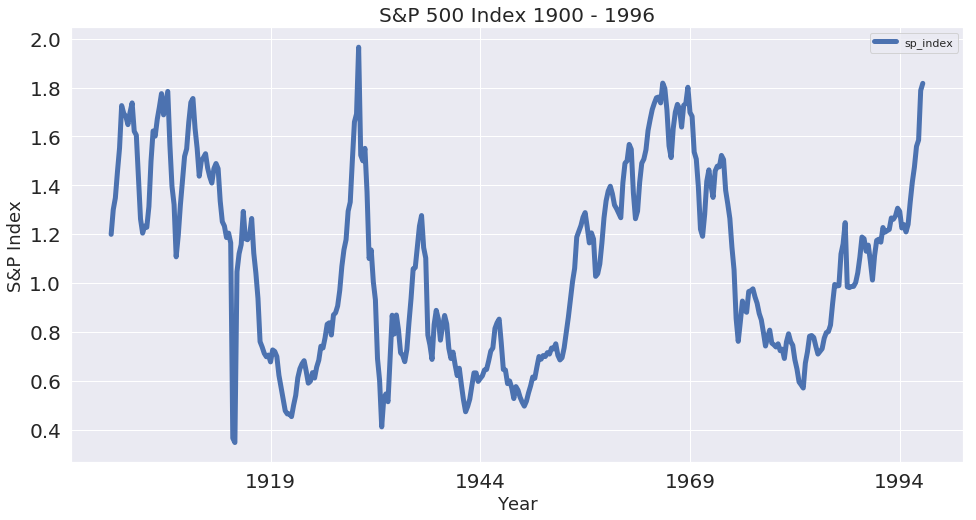

In [16]:
# Plot the time series
df.plot(figsize=(16,8), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('S&P Index', fontsize=18)
plt.title('S&P 500 Index 1900 - 1996', fontsize=20)

#### NOTE:

"The S&P 500 is considered an effective representation for the economy due to its inclusion of around 500 companies, which covers all areas of the United States and across all industries." [Taken from Investopedia](https://www.investopedia.com/ask/answers/040215/what-does-sp-500-index-measure-and-how-it-calculated.asp).

Text(0.5,1,'Index Distribution')

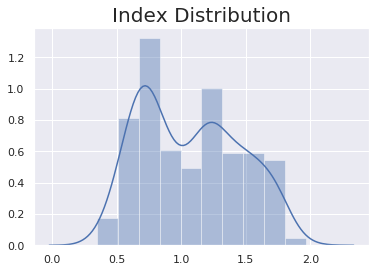

In [17]:
# Plot a histogram
sns.distplot(df)
plt.title('Index Distribution', fontsize=20)

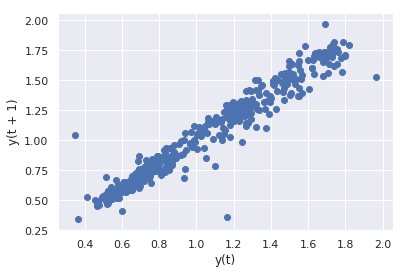

In [18]:
# Investigate the lag plot
pd.plotting.lag_plot(df)

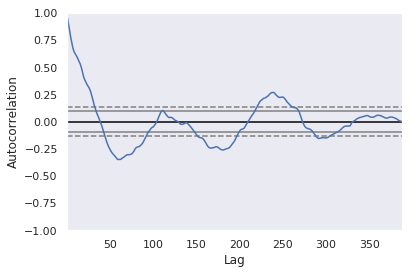

In [19]:
# Investigate the autocorrelation plot
pd.plotting.autocorrelation_plot(df)

### IV. Trends and seasonality

Text(0,0.5,'S&P Index')

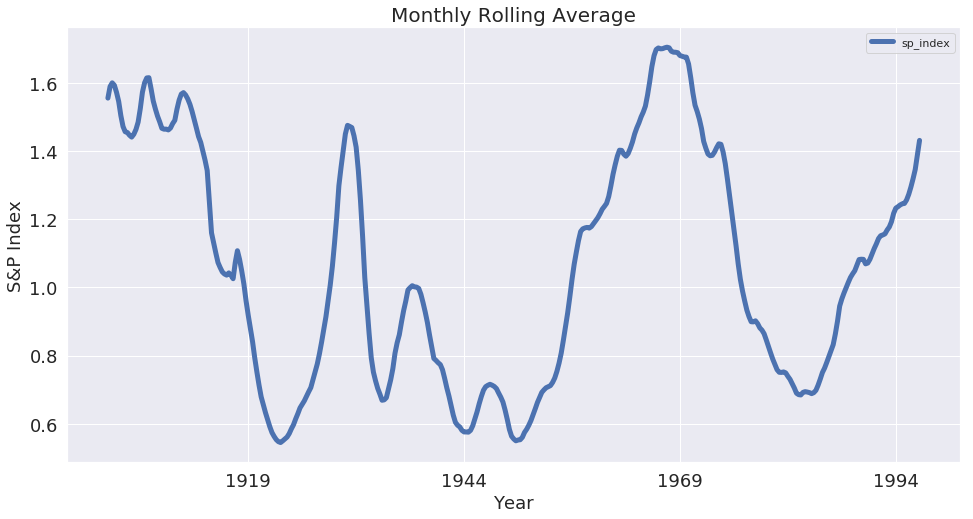

In [20]:
df.rolling(12).mean().plot(figsize=(16,8), linewidth=5, fontsize=18)
plt.title('Monthly Rolling Average', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('S&P Index', fontsize=18)

Taking this rolling average will smooth the noise in the data and the seasonality. We can now explore a litle into the seasonal pattern, if one exists. We will do this by removing the trend in the time series, to make looking at seasonality easier. We will do this with "differencing."

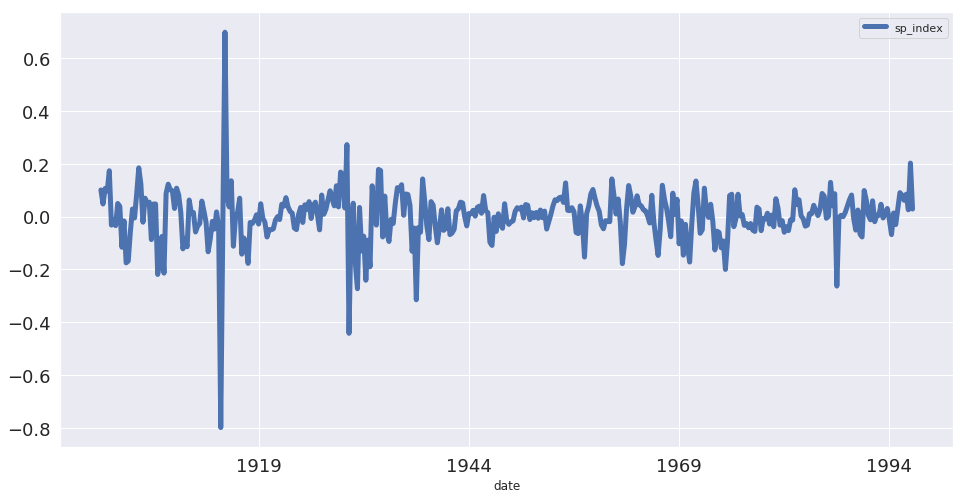

In [21]:
# first order differencing
df.diff().plot(figsize=(16,8), linewidth=5, fontsize=18)

With the trend removed we can really see the peaks in the data, including a very noticeable swing during what we now refer to as "The Great Depression." 

### V. Persistence forecast model

Establishing a baseline forecast. This is the simpleste forecast one can make: use the current time step to predict the next (naive forecast).

In [22]:
# Import some more useful tools
from sklearn.metrics import mean_squared_error
from math import sqrt

In [23]:
# Create the lagged dataset
values = pd.DataFrame(df.values)
model_df = pd.concat([values.shift(1), values], axis=1)
model_df.columns = ['t-1', 't+1']
model_df.head()

,t-1,t+1
0,NaN,1.199
1,1.199,1.300
2,1.300,1.348
3,1.348,1.455
4,1.455,1.552


In [24]:
# Train and test sets
X = model_df.values
train_size = int(len(X) * 0.70)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [25]:
# Persistence algorithm
def model_persistence(x):
    return(x)

Note that the persistence algorithm is intended to return the input value provided, as in, if the value of t-1 was provided as input then it is returned as the prediction, whereas the real/expected value (t+1).

In [26]:
# Walk-forward evaluation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.005


Text(0,0.5,'S&P Index')

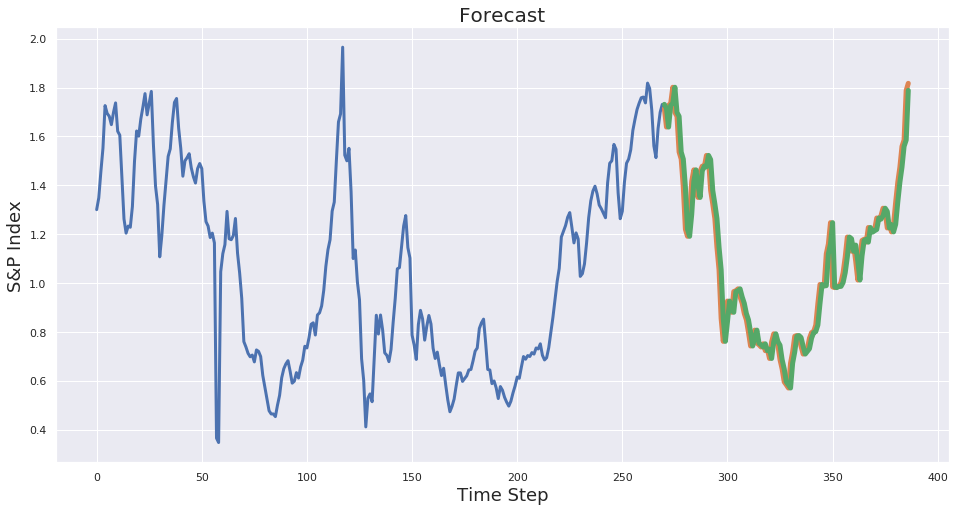

In [27]:
# Plot the predictions and expected values
plt.figure(figsize=(16,8))
plt.plot(train_y, linewidth=3)
plt.plot([None for i in train_y] + [x for x in test_y], linewidth=5)
plt.plot([None for i in train_y] + [x for x in predictions], linewidth=5)
plt.title("Forecast", fontsize=20)
plt.xlabel('Time Step', fontsize=18)
plt.ylabel('S&P Index', fontsize=18)

### VI. Autoregressive forecast model

Here we will be developing a linear model that will use observations at previous time steps to predict future observations. This is a quick and powerful forecasting method.

From [ML Mastery](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/), "If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.

The correlation statistics can also help to choose which lag variables will be useful in a model and which will not.

Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset."

Before performing an autocorrelation forecast, we need to check if there is any autocorrelation in our time series. Fortunately, we can check visually pretty quickly and we already did it in the visual EDA section above.

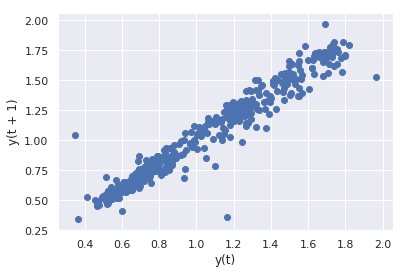

In [28]:
# Investigate the lag plot
pd.plotting.lag_plot(df)

There is a clear correlation between the time series and the lagged time series, as shown by the tight proximity and the diagonal line present. We could also perform this lag check on any number of lags, like last 2 quarters, etc.

Next we will use the PEarson correlation coefficient to calculate the correlation. -1: negatively correlated, +1: positively correlated, and values around 0 are low correlation.

In [29]:
# Look at the model_df, as we already did the work to make the lag series
model_df.head()

,t-1,t+1
0,NaN,1.199
1,1.199,1.300
2,1.300,1.348
3,1.348,1.455
4,1.455,1.552


In [30]:
model_df.corr()

,t-1,t+1
t-1,1.000000,0.968082
t+1,0.968082,1.000000


We are looking at strong ponsitevly correlated data here, with the lag = 1 value.

If we wanted to, we could scale this up a bit and look at multiple lag values and plot the correlation coefficient for each lag, which is useful for determining which value(s) of lag would be good for forecasting and investigating  how the relationship between current and historic observations change over time.

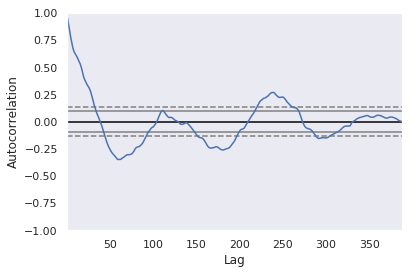

In [31]:
# Investigate the autocorrelation plot
pd.plotting.autocorrelation_plot(df)

In [32]:
# Import another tool for the autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf

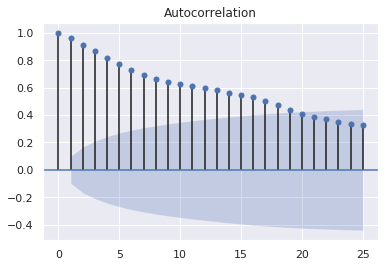

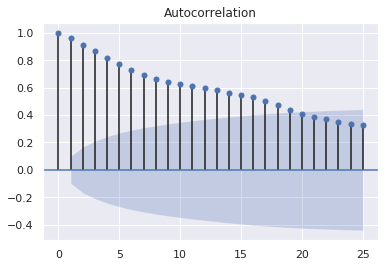

In [33]:
# Plot the autocorelation
plot_acf(df, lags=25)

This plot contains solid and dashed lines showing 95% and 99% confidence interval, respectively, for correlation values. Correlation values above these lines are more significant than those below the line. This will give us a threshold for selecting lag values that are more relevant.

Now we will develp the autocorrelation model.

In [34]:
# Import another tool for the model
from statsmodels.tsa.arima_model import ARMA

In [35]:
# Split the data for a 7-day forecast (use X from previous forecast above)
X = df.values
train, test = X[1:len(X)-7], X[len(X)-7:]

In [36]:
# Train the autoregression model
model = ARMA(train, order=(1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  380
Model:                     ARMA(1, 0)   Log Likelihood                 350.837
Method:                       css-mle   S.D. of innovations              0.096
Date:                Thu, 03 Jan 2019   AIC                           -695.674
Time:                        20:36:51   BIC                           -683.853
Sample:                             0   HQIC                          -690.983
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0886      0.136      8.031      0.000       0.823       1.354
ar.L1.y        0.9661      0.012     77.424      0.000       0.942       0.991
                                    Roots           

In [37]:
# Make forecast
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted for day %s = %f, expected = %f' % (i+1, predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted for day 1 = 1.234870, expected = 1.331000
predicted for day 2 = 1.229915, expected = 1.412000
predicted for day 3 = 1.225127, expected = 1.474000
predicted for day 4 = 1.220501, expected = 1.559000
predicted for day 5 = 1.216032, expected = 1.585000
predicted for day 6 = 1.211714, expected = 1.788000
predicted for day 7 = 1.207542, expected = 1.817000
Test MSE: 0.151


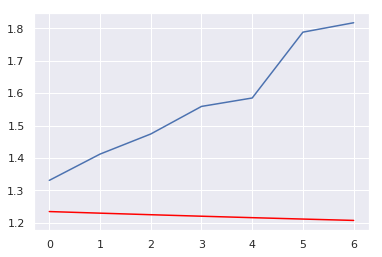

In [38]:
# Show the results
plt.plot(test)
plt.plot(predictions, color='red')

Does not look good.

### VII. ARIMA Forecast

An ARIMA forecast is a clasical linear model for time series that comnbines autoregressive model (AR) and moving avegare (MA) while removing trends and seasonality, which is called integrating (I). Put it together to get ARIMA. These three components are also explicitely specified by the model as paramters, *p*, *d*, and *q*. This looks like:

$
ARIMA(p,d,q)
$

+ *p*: number of lag observations included in the model (aka: lag order).
+ *d*: number of times the raw observations are differenced (aka: degree of differencing).
+ *q*: size of the moving average window (aka: order of moving average).

From [ML Mastery](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/), "A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model."

In [39]:
# Import the model
from statsmodels.tsa.arima_model import ARIMA

In [40]:
# Define and fit the model
model = ARIMA(df.values, order=(5,1,0))  # lag value: 5 autoregressions, difference order 1, 0 order moving average
model_fit = model.fit(disp=0)  # disp=0 to turn off debug info
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  387
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 368.868
Method:                       css-mle   S.D. of innovations              0.093
Date:                Thu, 03 Jan 2019   AIC                           -723.735
Time:                        20:36:51   BIC                           -696.026
Sample:                             1   HQIC                          -712.748
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.005      0.267      0.790      -0.009       0.012
ar.L1.D.y      0.2419      0.051      4.769      0.000       0.142       0.341
ar.L2.D.y     -0.1103      0.052     -2.106      0.036      -0.213      -0.008
ar.L3.D.y      0.0947      0.052      1.804      0.072      -0.008       0.198
ar.L4.D.y     -0.0363      0.052     -0.694      0.488      -0.139       0.066
ar.L5.D.y     -0.0749      0.051     -1.465      0.144      -0.175       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3124           -0.8663j            1.5725           -0.0929
AR.2            1.3124           +0.8663j            1.5725            0.0929
AR.3           -0.4487           -1.4964j            1.5622           -0.2964
AR.4           -0.4487           +1.4964j            1.5622            0.2964
AR.5           -2.2128           -0.0000j            2.2128           -0.5000
-----------------------------------------------------------------------------
"""

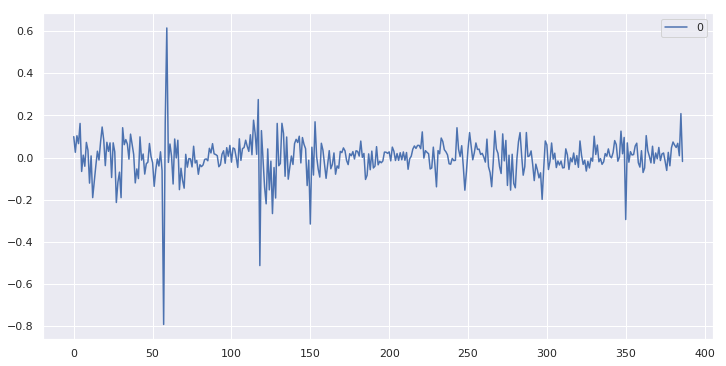

In [41]:
# Display residual errors
residuals_df = pd.DataFrame(model_fit.resid)
residuals_df.plot(figsize=(12,6))

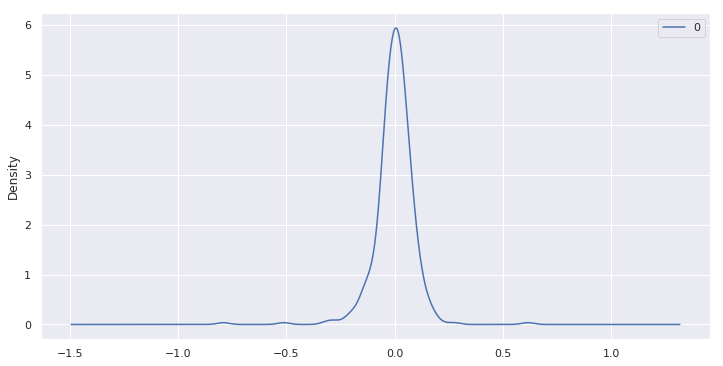

In [42]:
# Plot the density plot for residual error values (residuals)
residuals_df.plot(kind='kde', figsize=(12,6))

The errors are Gausssian and centered at zero, so no bias.

In [43]:
residuals_df.describe()

,0
count,387.000000
mean,0.000061
std,0.093406
min,-0.791101
25%,-0.034703
50%,0.007277
75%,0.043961
max,0.614850


The mean of the residuals is very close to zero, so there is indeed no bias in the data.

Now we will make a forecast with ARIMA.

In [44]:
# Split the data nto train and test sets
X = df.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=1.759907, expected=1.714000
predicted=1.711027, expected=1.638000
predicted=1.614238, expected=1.727000
predicted=1.751776, expected=1.735000
predicted=1.716013, expected=1.801000
predicted=1.834123, expected=1.698000
predicted=1.667423, expected=1.682000
predicted=1.694309, expected=1.536000
predicted=1.489974, expected=1.507000
predicted=1.518881, expected=1.392000
predicted=1.363589, expected=1.220000
predicted=1.199140, expected=1.191000
predicted=1.204175, expected=1.281000
predicted=1.295530, expected=1.416000
predicted=1.453310, expected=1.463000
predicted=1.482582, expected=1.400000
predicted=1.390281, expected=1.350000
predicted=1.336817, expected=1.458000
predicted=1.472582, expected=1.478000
predicted=1.464446, expected=1.475000
predicted=1.490604, expected=1.522000
predicted=1.534185, expected=1.505000
predicted=1.486773, expected=1.379000
predicted=1.355168, expected=1.324000
predicted=1.323550, expected=1.264000
predicted=1.241295, expected=1.146000
predicted=1.

In [45]:
# Mean squared error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.005


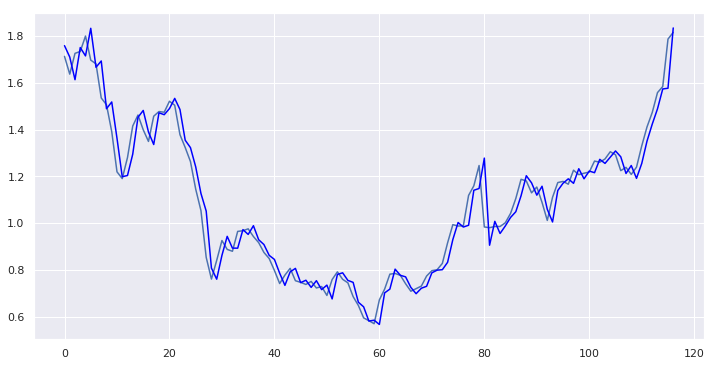

In [46]:
# Visualize the forecast against the test data set
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='blue')

Not perfect, but markedly better of a forcast than the last section's forecast.